In [24]:
using Gen
using PyPlot
using Distributions

In [2]:
function desired_next_step(u::String, x::Float64, y::Float64)
    if u == "U"
        y += 1.
    elseif u == "D"
        y += -1.
    elseif u == "R"
        x += 1.
    elseif u == "L"
        x += -1.
    end
    return x,y
end

desired_next_step (generic function with 1 method)

### Generative Controlled Robot Program

In [19]:

#each index matches whether it was broken or not on that location. For instance the first position is always not
function controlled_robot_program(T::Trace, user_controls::Array{String,1})
    possible_controls = ["R","U","L","D"]
    
    curr_x = 0.
    curr_y = 0.
    
    dxs = []
    dys = []
    b = []
    
    for i=1:length(user_controls)
        
        #Determine if the robot breaks or not
        #..or if already broken, stay broken
        if i != 1 && b[i-1]
            push!(b, flip(1) ~ "b$i") 
        else
            push!(b, flip(0.2) ~ "b$i")
        end
        
        #Given if it's broken, determine the 'control'
        if b[i]
            #randomly sample new control
            u = possible_controls[rand(1:4)]
        else
            u = user_controls[i] # R, U, L , or D
        end
        
        #Given the 'control', gives the position of what the next desired step is 
        desired_x, desired_y = desired_next_step(u, curr_x, curr_y)
        
        #Just for likelihood check later
        push!(dxs, desired_x)
        push!(dys, desired_y)
        
        #Add some noise to the desired next step
        curr_x = normal(desired_x, 0.075) ~ "x$i"
        curr_y = normal(desired_y, 0.075) ~ "y$i"
        
    end
    return dxs, dys
end
    

controlled_robot_program (generic function with 1 method)

### Contrain X and Y and Manually Compute Likelihood

In [38]:
#---------------------------------
#Run Program and show log_weight
#---------------------------------

u = ["R","U","L","D"]
robot_trace = Trace()

xs = [0.97,0.87,-0.20,-0.16]
ys = [-0.10, 0.93, 0.92, -0.17]

for i=1:length(u)
    robot_trace["x$i"] = xs[i]
    robot_trace["y$i"] = ys[i]
end 

dxs, dys = controlled_robot_program(robot_trace, u)
println("robot_trace.log_weight: $(robot_trace.log_weight)")

#---------------------------------
#Compute the likelihood manually
#---------------------------------

P=0
for i=1:4
    P += logpdf(Normal(dxs[i], 0.075), xs[i])
    P += logpdf(Normal(dys[i], 0.075), ys[i])
end
    
println("manual likelihood: $P") 

robot_trace.log_weight: -190.76270427540413
manual likelihood: -190.76270427540413


### Show the path of the robot. 

#### Red means the direction was chosen while broken (randomly)

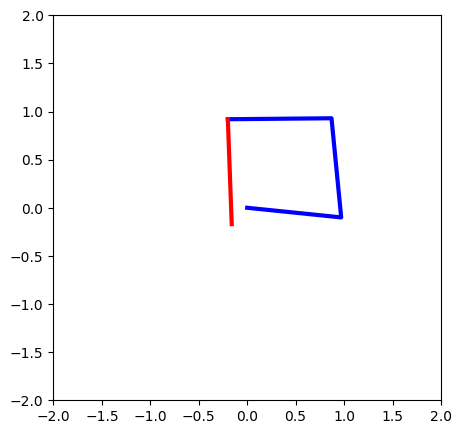

(-2,2)

In [41]:
plt[:figure](figsize=(5, 5))

zero_start_xs = [0.]
zero_start_ys = [0.]

zero_start_xs = vcat(zero_start_xs, map((i) -> robot_trace["x$i"], 1:length(u)))
zero_start_ys = vcat(zero_start_ys, map((i) -> robot_trace["y$i"], 1:length(u)))

bs = map((i) -> robot_trace["b$i"], 1:length(u))
broken_index = findfirst(bs, true)
if broken_index != 0
    plt[:plot](zero_start_xs[1:broken_index], zero_start_ys[1:broken_index], color="blue", lw=3)
    plt[:plot](zero_start_xs[broken_index:end], zero_start_ys[broken_index:end], color="red", lw=3)
else
    plt[:plot](zero_start_xs, zero_start_ys, color="blue", lw=3)
end

plt[:xlim](-2,2)
plt[:ylim](-2,2)



In [7]:
function render_observed_path_trace(trace::Trace,
                                         xs::Array{Float64,1}, ys::Array{Float64,1},
                                         ax, xlim, ylim)
    
    zero_start_xs = [0.]
    zero_start_ys = [0.]

    zero_start_xs = vcat(zero_start_xs, xs)
    zero_start_ys = vcat(zero_start_ys, ys)

    bs = map((i) -> trace["b$i"], 1:length(xs))
    broken_index = findfirst(bs, true)
    if broken_index != 0
        ax[:plot](zero_start_xs[1:broken_index], zero_start_ys[1:broken_index], color="blue", lw=3)
        ax[:plot](zero_start_xs[broken_index:end], zero_start_ys[broken_index:end], color="red", lw=3)
    else
        ax[:plot](zero_start_xs, zero_start_ys, color="blue", lw=3)
    end

    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
    
end

render_observed_path_trace (generic function with 1 method)

### Run `controlled_robot_program` 36 times (Prior)
## Without Contraints


In [43]:
traces = []
u = ["R","U","L","D"]
log_weights = []
observed_xs = []
observed_ys = []
for replicate=1:36
    trace = Trace()
    controlled_robot_program(trace, u)
    push!(observed_xs, map((i) -> trace["x$i"], 1:length(u)))
    push!(observed_ys, map((i) -> trace["y$i"], 1:length(u)))
    push!(traces, trace)
    push!(log_weights, trace.log_weight)
end

### Plot Priors

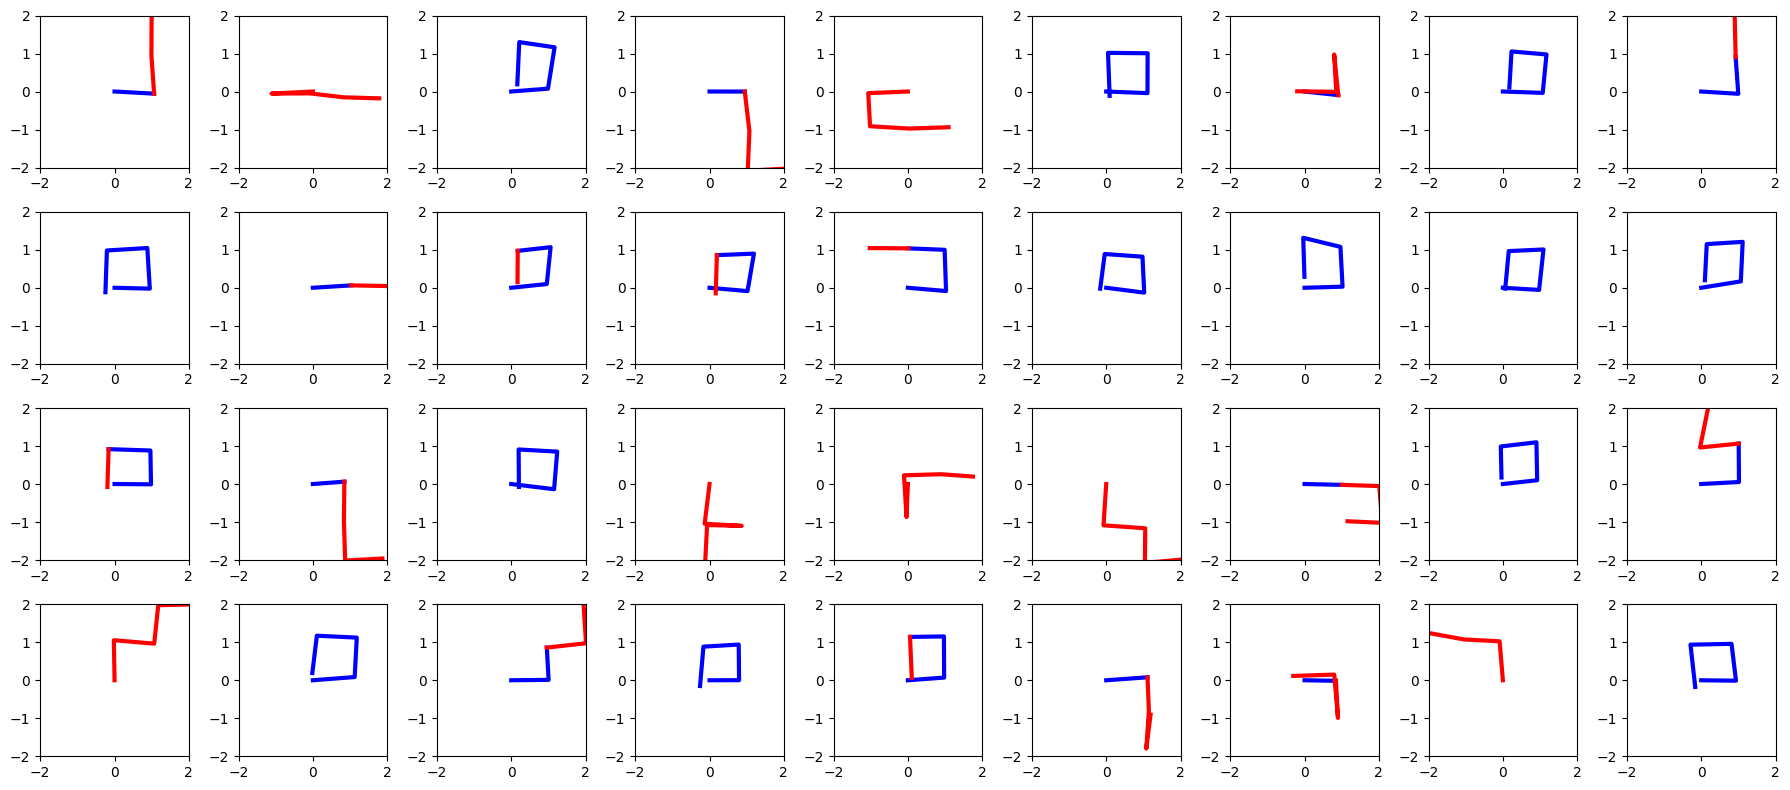

In [45]:
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-2., 2.]
    ylim = [-2., 2.]
    #ax[:title][:set_text](log_weights[i])
    render_observed_path_trace(trace, observed_xs[i], observed_ys[i], ax, xlim, ylim)
end
plt[:tight_layout]()

### Run `controlled_robot_program` 36 times (Posterior)
### Contraining X and Y and viewing likelihoods

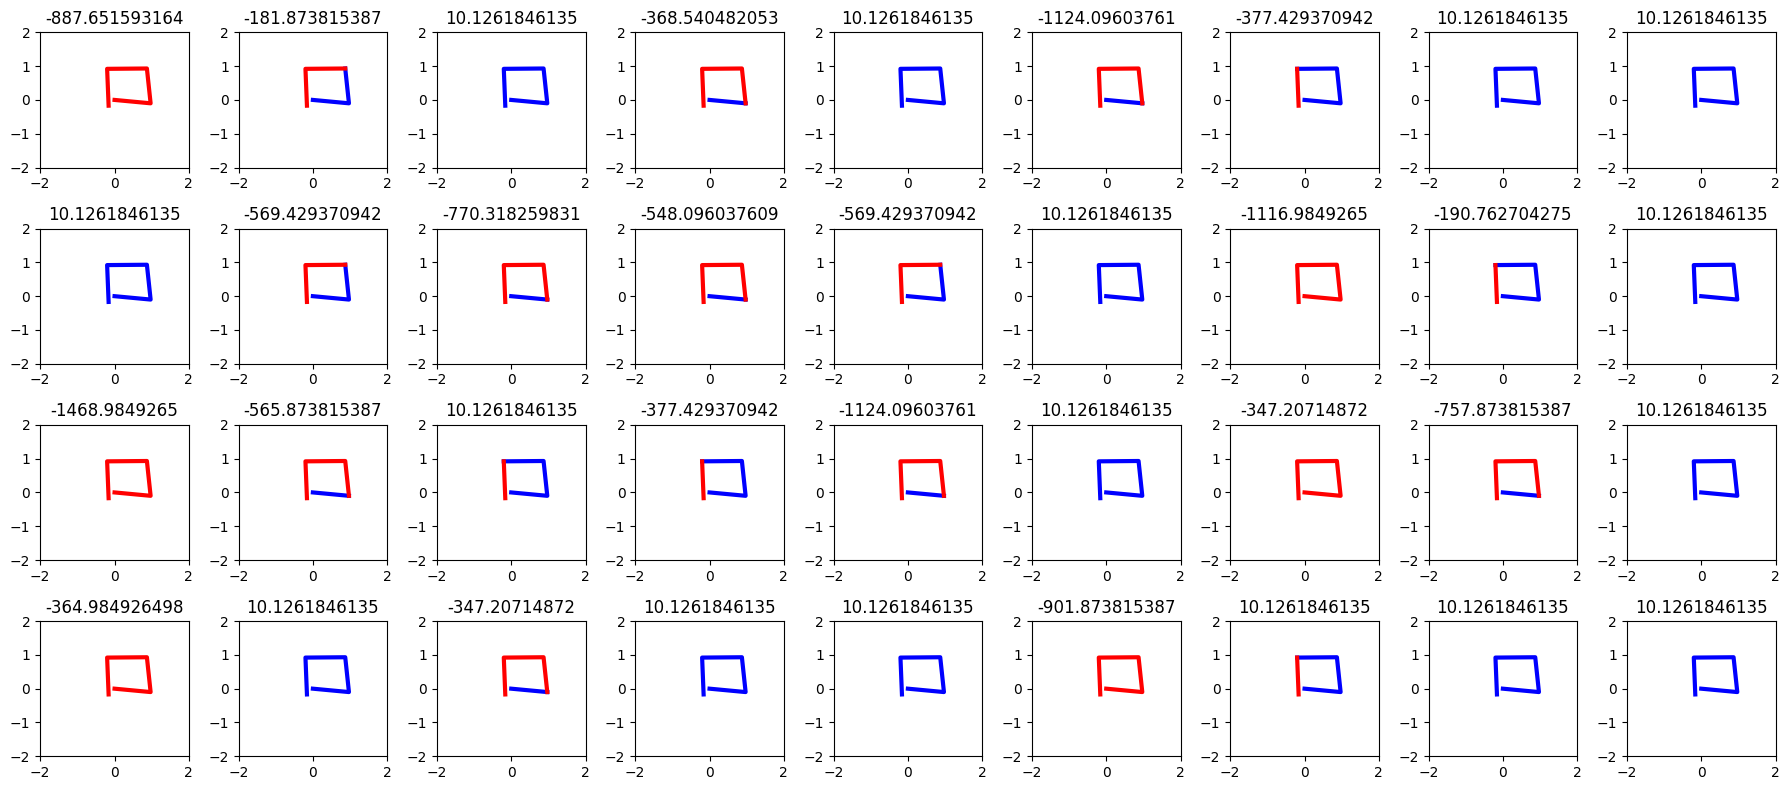

In [47]:
traces = []
u = ["R","U","L","D"]
log_weights = []
xs = [0.97,0.87,-0.20, -0.16]
ys = [-0.10, 0.93, 0.92, -0.17]
for replicate=1:36
    trace = Trace()
    
    for i=1:length(u)
        trace["x$i"] = xs[i]
        trace["y$i"] = ys[i]
    end 
    
    controlled_robot_program(trace, u)
    push!(traces, trace)
    push!(log_weights, trace.log_weight)
end

#----------------------------------
# PLOT
#----------------------------------

plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-2., 2.]
    ylim = [-2., 2.]
    ax[:title][:set_text](log_weights[i])
    render_observed_path_trace(trace, xs, ys, ax, xlim, ylim)
end
plt[:tight_layout]()